In [1]:
using Distributions

First we'll make some data, and try to see how well the regression recovers the parameters.

In [2]:
# Generate some data

a = 0.45
b = 4.2

n_samples = 20

xs = zeros(n_samples)
ys = zeros(n_samples)

for i in 1:n_samples
    x = rand(Normal())
    xs[i] = x
    ys[i] = a * x + b + rand(Normal(0, 0.5))
end

In [3]:
using Plots

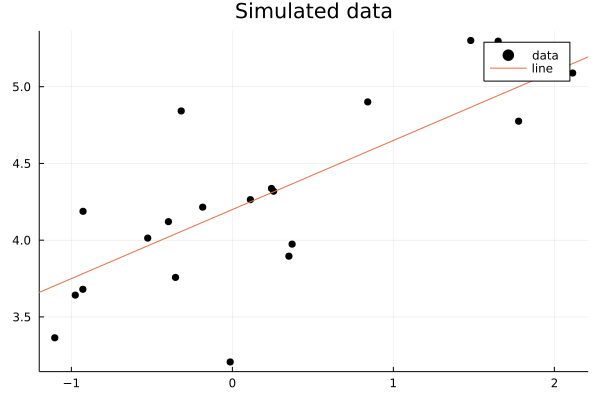

In [4]:
p = scatter(xs, ys, label="data", color="black", title="Simulated data")

Plots.abline!(p, a, b, label="line")

In [5]:
savefig(p, "figures/linear_data.pdf")

# Frequentist model

We'll try to fit a small model, in frequentist and bayesian case.

In [6]:
using GLM

In [7]:
using DataFrames

In [8]:
dataframe = DataFrame(:x => xs, :y => ys) |> df -> sort(df, :x)

,x,y
,Float64,Float64
1,-1.10318,3.36399
2,-0.975811,3.64212
3,-0.928665,3.67992
4,-0.927599,4.18809
5,-0.525776,4.01377
6,-0.3971,4.1208
7,-0.353138,3.75752
8,-0.317799,4.84217
9,-0.184254,4.21522


In [9]:
lm_freq = lm(@formula(y ~ 1 + x), dataframe)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  4.17399    0.0897322  46.52    <1e-19   3.98547     4.36251
x            0.491089   0.0939641   5.23    <1e-04   0.293677    0.6885
────────────────────────────────────────────────────────────────────────

To look how our model looks, we'll plot predictions.

In [10]:
μ_y = predict(lm_freq, dataframe)

20-element Vector{Union{Missing, Float64}}:
 3.6322271920240907
 3.694777442585105
 3.7179300676246787
 3.7184533678995955
 3.915784254515403
 3.9789756459593453
 4.000564995178446
 4.0179195586519345
 4.083502000524095
 4.167377225149363
 4.22901842990133
 4.293295179642563
 4.299812208362454
 4.346437646587903
 4.3562727281814135
 4.586934154780439
 4.901156772407126
 4.984755164901693
 5.047167447238598
 5.21202460866888

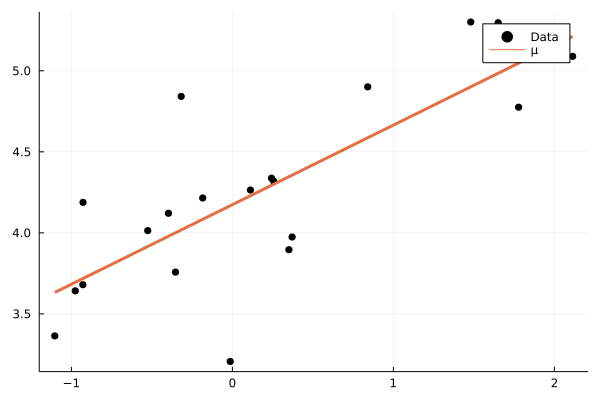

In [11]:
p = scatter(dataframe[!,:x], dataframe[!,:y], label="Data", color="black")
plot!(p, dataframe[!,:x], μ_y, label="μ", w=3)

# Confidence and Prediction Intervals

In [12]:
conf_int = predict(lm_freq, dataframe, interval=:confidence);

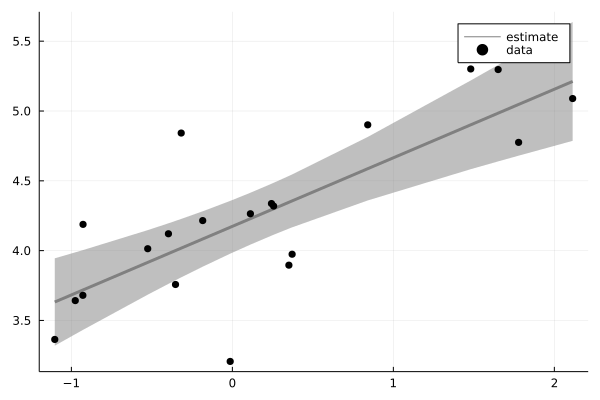

In [13]:
plot(dataframe[!,:x], μ_y, ribbon=(conf_int[!,:upper] .- μ_y,
                                   μ_y .- conf_int[!,:lower]),
     color="grey", label="estimate", w=3)
scatter!(dataframe[!,:x], dataframe[!,:y], label="data", color="black")
# plot!(dataframe[!,:x], conf_int[!,:upper], color="grey", label=missing)
# plot!(dataframe[!,:x], conf_int[!,:lower], color="grey", label=missing)

In [14]:
pred_int = predict(lm_freq, dataframe, interval=:prediction);

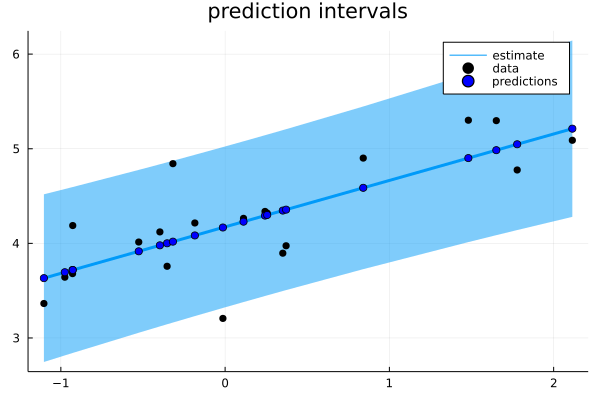

In [15]:
p = plot(dataframe[!,:x], μ_y, ribbon=(pred_int[!,:upper] .- μ_y,
                                       μ_y .- pred_int[!,:lower]),
      label="estimate", title="prediction intervals", w=3)

scatter!(p, dataframe[!,:x], dataframe[!,:y], label="data", color="black")
scatter!(dataframe[!,:x], pred_int[!,:prediction], color="blue", label="predictions")
# plot!(dataframe[!,:x], pred_int[!,:lower], color="green", label=missing)
# plot!(dataframe[!,:x], pred_int[!,:upper], color="green", label=missing)

In [16]:
savefig(p, "figures/linear_prediction_interval.pdf")

We can see that the *prediction intervals* include the error around the line. But do they include the error *in* the lines (that we see the confidence intervals have different widths!)

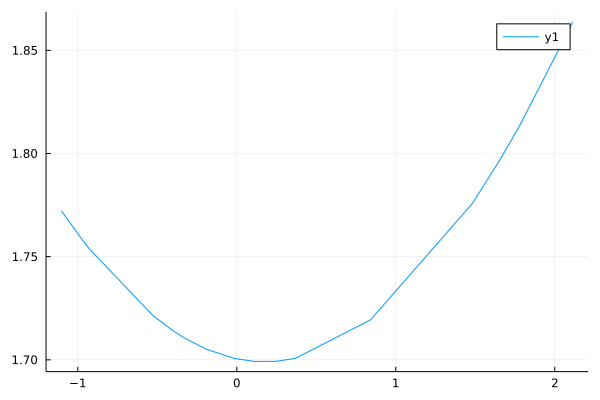

In [17]:
plot(dataframe[!,:x], pred_int[!,:upper] .- pred_int[!,:lower])

The answer is yes. They also include the uncertainty as to where the line is!

# Bootstrapping

I have read that the bootstrap is a good way to make estimations about the uncertainty of a statistical method (Elements of Statistical Learning, Chapter 8)

In [22]:
function bootstrap(B, data)
    L = nrow(data)
    
    sets = []
    for b in 1:B
        indexes = rand(1:L, L)
        append!(sets, [data[indexes,:]])
    end
    return sets
end

bootstrap (generic function with 1 method)

In [78]:
fits = bootstrap(500, dataframe) |>
    dfs -> map(df -> lm(@formula(y ~ 1 + x), df), dfs);

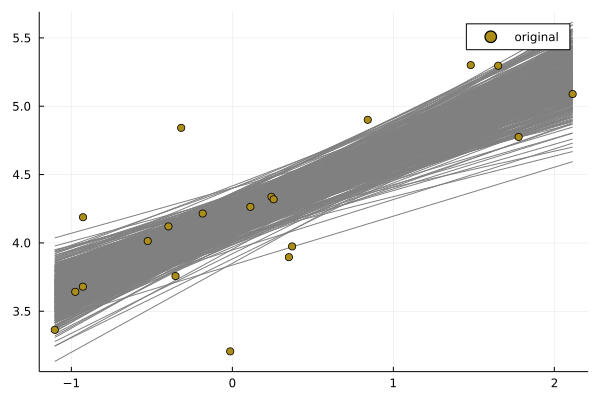

In [79]:
p = plot()

for line in fits
    plot!(dataframe[!,:x], predict(line, dataframe), label=missing,
        color="gray") 
end

scatter!(dataframe[!,:x], dataframe[!,:y], label="original")
p

In [80]:
using StatsPlots

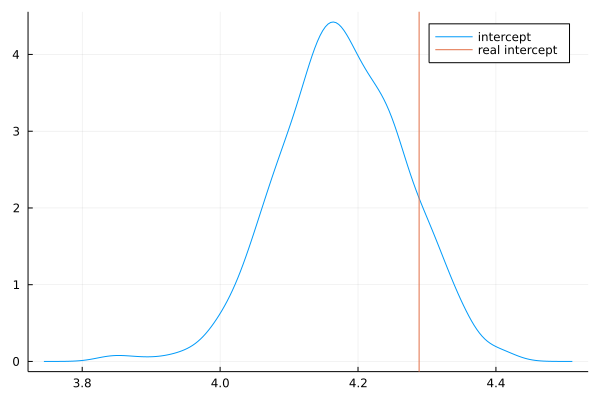

In [81]:
intercept_dist = map(l -> coef(l)[1], fits);
slope_dist = map(l -> coef(l)[2], fits);

density(intercept_dist, label="intercept")
vline!([b], label="real intercept")

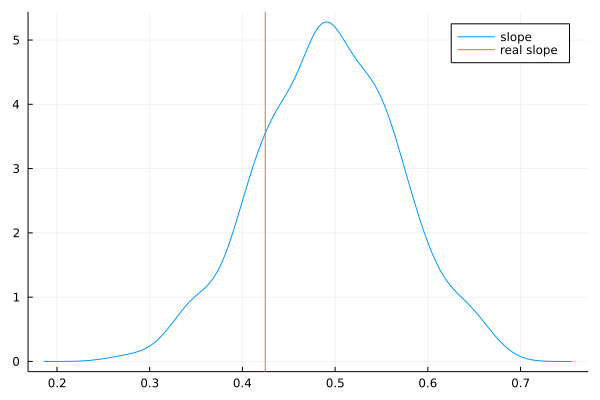

In [82]:
density(slope_dist, label="slope")
vline!([a], label="real slope")

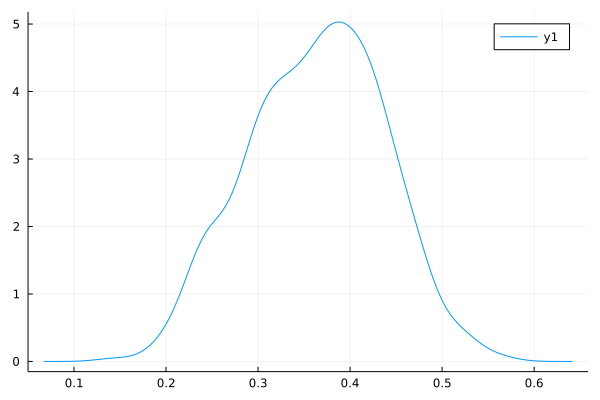

In [99]:
residuals_std_dist = map(x -> std(residuals(x)), fits)
density(residuals_std_dist)

# Bayesian model

In [83]:
using Turing

In [84]:
@model function linear(xs, ys)
    l = length(xs)
    
    # Priors for lines
    a ~ Normal(0, 1)
    b ~ Normal(0, 3)
    
    # Prior for variance of points with line
    sigma ~ Exponential(0.2)
    
    for i in 1:l
        expected = a * xs[i] + b
        ys[i] ~ Normal(expected, sigma)
    end
    
    return ys
end

linear (generic function with 2 methods)

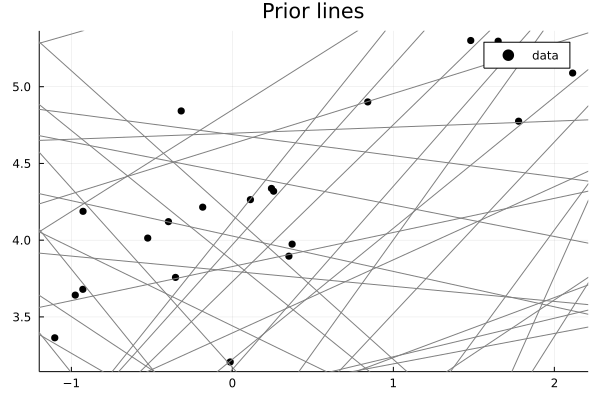

In [85]:
# Sampling from prior

N = 100
as = rand(Normal(0, 1), N)
bs = rand(Normal(0, 3), N)

p = scatter(dataframe[!,:x], dataframe[!,:y], label="data", title="Prior lines",
    color="black")
for i in 1:N
    Plots.abline!(p, as[i], bs[i], label=missing, color="gray")
end

p

In [86]:
savefig(p, "figures/linear_prior_lines.pdf")

In [87]:
model = linear(xs, ys)
chain = sample(model, NUTS(0.65), 2000)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/noric/.julia/packages/Turing/Tpj0b/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (2000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 1.22 seconds
Compute duration  = 1.22 seconds
parameters        = a, b, sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           a    0.4871    0.0927     0.0021    0.0022   2182.8114    0.9996    ⋯
           b    4.1718    0.0923     0.0021    0.0023   2057.7625    0.9996    ⋯
       sigma    0.4001    0.0671     0.0015    0.0016   1850.1266    0.9998    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0

In [88]:
using StatsPlots

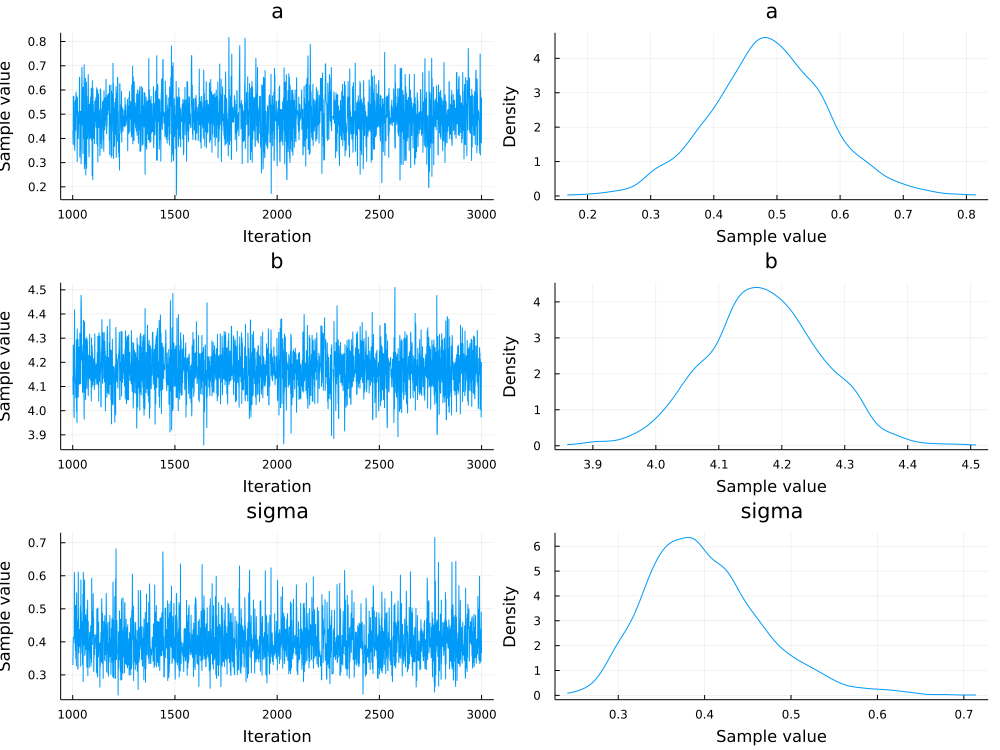

In [89]:
plot(chain)

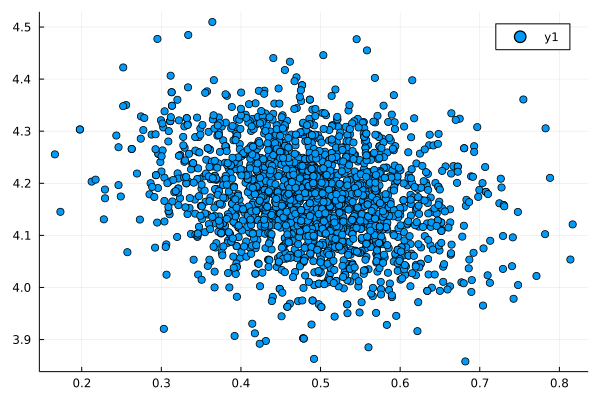

In [90]:
scatter(chain[:a], chain[:b])

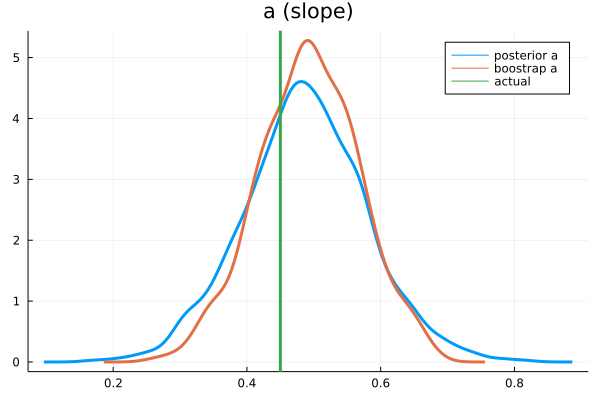

In [91]:
p_a = density(chain[:a], label="posterior a", title="a (slope)", w=3)

density!(slope_dist, label="boostrap a", w=3)
vline!(p_a, [0.45], label="actual", w=3)

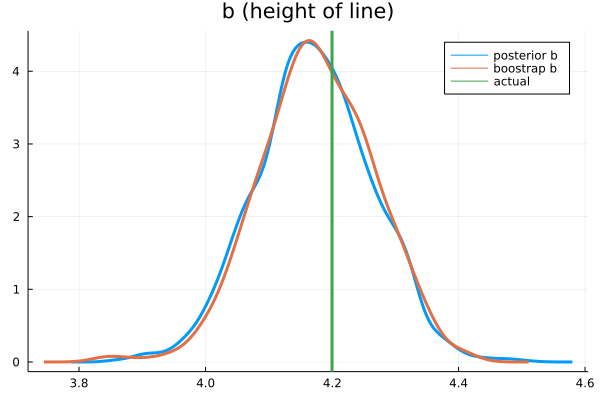

In [93]:
p_b = density(chain[:b], label="posterior b", title="b (height of line)", w=3)
density!(intercept_dist, label="boostrap b", w=3)
vline!(p_b, [4.2], label="actual", w=3)

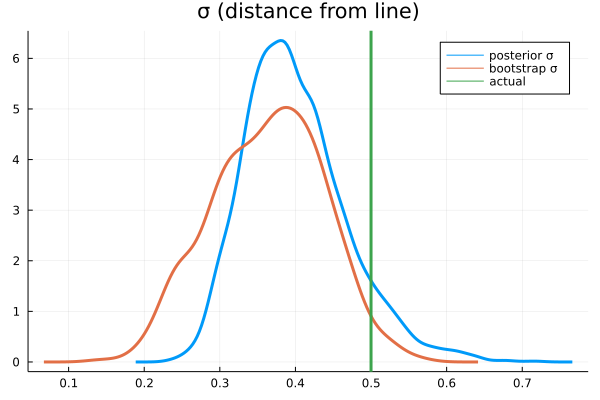

In [100]:
p_σ = density(chain[:sigma], label="posterior σ", title="σ (distance from line)", w=3)

density!(residuals_std_dist, label="bootstrap σ", w = 3)
# plot!(p_σ, Exponential(0.2), label="prior σ", color="gray", w=3)

vline!(p_σ, [0.5], label="actual", w=3)

It seems that the bootstrap estimates works, but it under-estimates it a bit. We know that bootstrap estimates of dispersion are a bit biased, because you're less likely to see extreme variables.

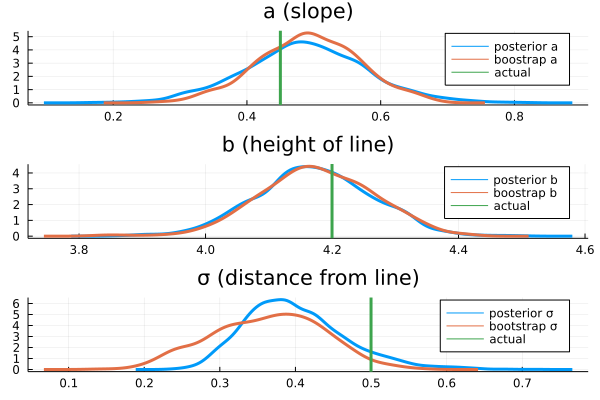

In [101]:
p_posteriors = plot(p_a, p_b, p_σ, layout=(3,1))

In [102]:
savefig(p_posteriors, "figures/posterior_parameters.pdf")

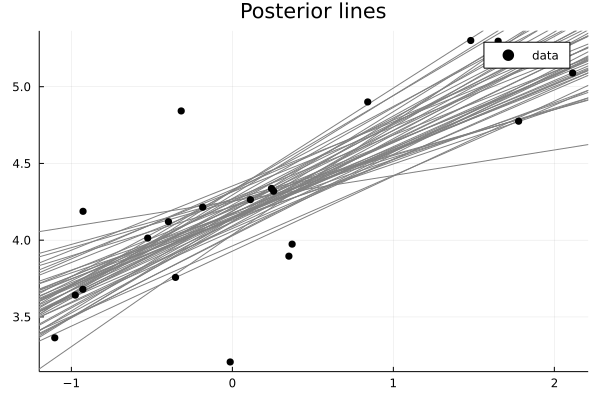

In [103]:
p = plot(title="Posterior lines")

for i in 1:50
    id = rand(1:2000)
    a = chain[:a][id]
    b = chain[:b][id]
    
    Plots.abline!(p, a, b,
        label=missing,
        color="gray")
end

scatter!(p, dataframe[!, :x], dataframe[!,:y], color="black", label="data")

p

In [104]:
savefig(p, "figures/posterior_lines.pdf")

We see we get a distribution of many lines, which show the uncertainty. 
Now, how do you make predictions with such a model? 

# Bayesian predictions

In [34]:
# Prediction
model = linear([0.0, 1.0], [missing, missing])

prediction = predict(model, chain)

Chains MCMC chain (2000×2×1 Array{Float64, 3}):

Iterations        = 1:1:2000
Number of chains  = 1
Samples per chain = 2000
parameters        = ys[1], ys[2]
internals         = 

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

       ys[1]    3.9767    0.4600     0.0103    0.0087   1896.1368    1.0011
       ys[2]    4.5332    0.4611     0.0103    0.0109   1706.7286    0.9995

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       ys[1]    3.1263    3.6723    3.9635    4.2766    4.9022
       ys[2]    3.6284    4.2305    4.5290    4.8355    5.4027


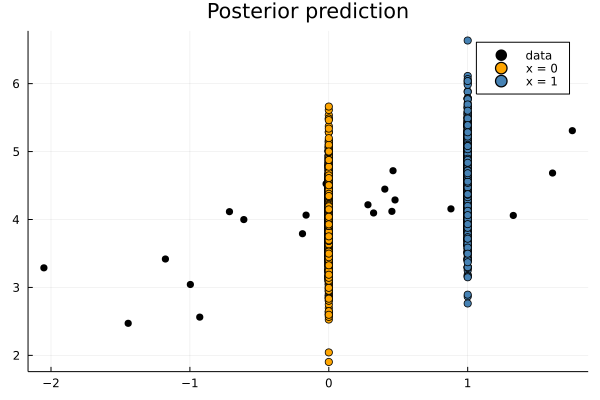

In [35]:
p = scatter(dataframe[!, :x], dataframe[!,:y], color="black", label="data",
    title="Posterior prediction")

scatter!(repeat([0.0], 2000), prediction["ys[1]"], label="x = 0", color="orange")
scatter!(repeat([1.0], 2000), prediction["ys[2]"], label="x = 1", color="steelblue")

In [36]:
savefig(p, "figures/predictions.pdf")

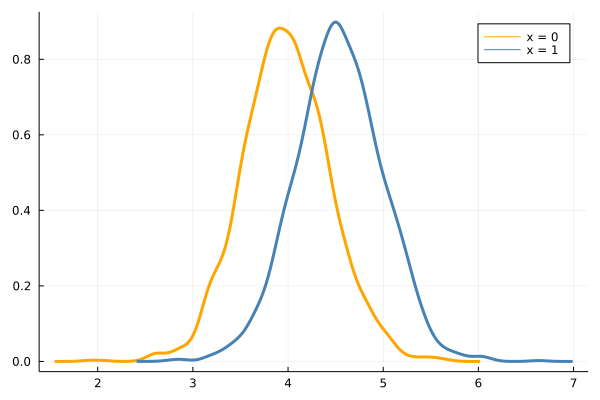

In [37]:
p_predictions = density(prediction["ys[1]"], label="x = 0", color="orange", w=3)
density!(p_predictions, prediction["ys[2]"], label="x = 1", color="steelblue", w=3)

In [38]:
savefig(p_predictions, "figures/prediction_distrubtions.pdf")

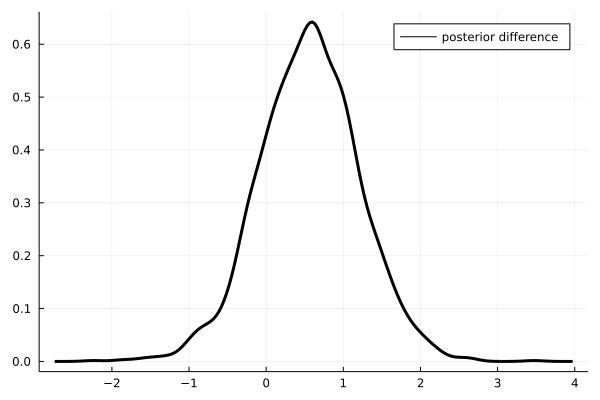

In [39]:
p = density(prediction["ys[2]"] .- prediction["ys[1]"], color="black", w=3, label="posterior difference")

In [40]:
savefig(p, "figures/prediction_difference.pdf")

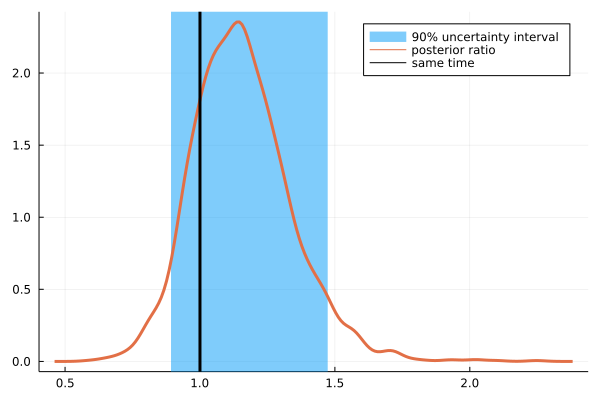

In [41]:
ratios = prediction["ys[2]"] ./ prediction["ys[1]"]
p_ratios = vspan(quantile(vec(ratios), [0.05, 0.95]), alpha=0.5, label="90% uncertainty interval")
density!(ratios, w=3, label="posterior ratio")
vline!(p_ratios, [1.0], color="black", w=3, label="same time")


In [42]:
savefig(p_ratios, "figures/posterior_ratio_prediction.pdf")

In [43]:
println(length(filter(x -> x > 1, ratios)) / length(ratios) |> x -> round(x, digits=2))
println(length(filter(x -> x <= 1, ratios)) / length(ratios) |> x -> round(x, digits=2))

0.81
0.19


# Interactions

This time, we'll consider we have two lines.

This is a reason to show a hierarchical model, that's how we add some hyperpriors. 

In [44]:
function generate_interaction()
    # Number of points
    N = 100
    
    a1 = 1.15
    a2 = 0.8
    
    b1 = 2.0
    b2 = 2.3
    
    # Samples don't have the same size.
    p = 0.6
    
    xs = rand(Normal(), N)
    ys = zeros(N)
    cs = zeros(N)
    
    stdev = 1.0 
    
    for i in 1:N
        coin = rand(Bernoulli(p))
        cs[i] = coin
        if coin == 1
            mean = a1 * xs[i] + b1
            ys[i] = rand(Normal(mean, stdev))
        else
            mean = a2 * xs[i] + b2
            ys[i] = rand(Normal(mean, stdev))
        end
    end
    return (xs, ys, cs)
end

generate_interaction (generic function with 1 method)

In [45]:
(xs, ys, cs) = generate_interaction()
interaction_samples = DataFrame(:x => xs, :flip => cs, :y => ys) |> df -> sort(df, :x)

,x,flip,y
,Float64,Float64,Float64
1,-2.52844,1.0,0.414519
2,-2.41612,1.0,-0.999146
3,-2.00695,0.0,-0.264414
4,-1.93104,0.0,-0.34219
5,-1.82556,0.0,-1.00276
6,-1.6501,0.0,0.117643
7,-1.38782,0.0,0.102328
8,-1.3598,0.0,1.74837
9,-1.35631,1.0,0.320618


In [46]:
red_samples = filter(r -> r[:flip] == 0.0, interaction_samples)
blue_samples = filter(r -> r[:flip] == 1.0, interaction_samples)

,x,flip,y
,Float64,Float64,Float64
1,-2.52844,1.0,0.414519
2,-2.41612,1.0,-0.999146
3,-1.35631,1.0,0.320618
4,-1.3226,1.0,0.254182
5,-1.21091,1.0,-0.063573
6,-0.875495,1.0,-0.447188
7,-0.779928,1.0,1.49664
8,-0.760352,1.0,2.50124
9,-0.722557,1.0,2.45845


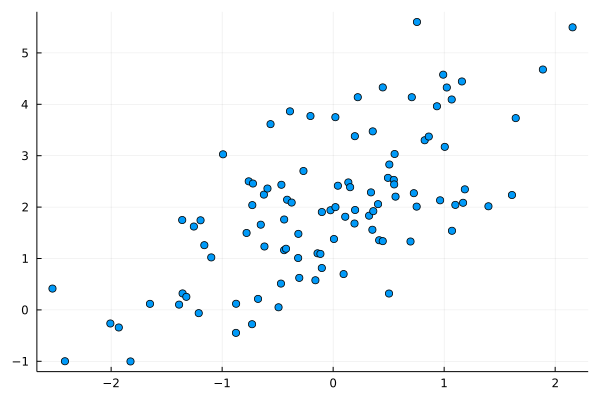

In [57]:
scatter(interaction_samples[!,:x], interaction_samples[!,:y], label=missing)

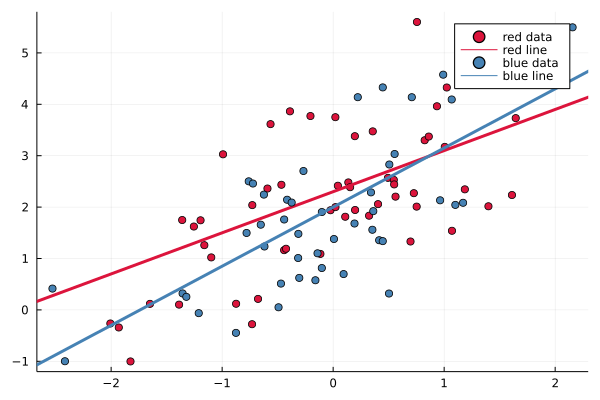

In [47]:
red_blue_plot = scatter(red_samples[!,:x], red_samples[!,:y], color="crimson", label="red data")
Plots.abline!(red_blue_plot, 0.8, 2.3, w=3, color="crimson", label="red line")

blue_plot = scatter!(red_blue_plot, 
    blue_samples[!,:x], blue_samples[!,:y], color="steelblue", label="blue data")
Plots.abline!(red_blue_plot, 1.15, 2.0, w=3, color="steelblue", label="blue line")

In [48]:
savefig(red_blue_plot, "figures/plot_interaction.pdf")

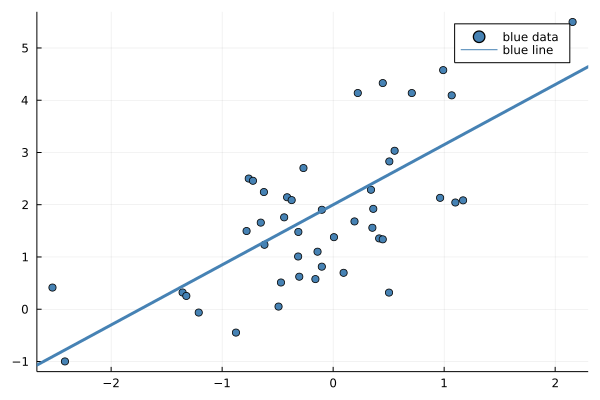

In [49]:
red_plot = scatter(red_samples[!,:x], red_samples[!,:y], color="crimson", label="red data")
Plots.abline!(red_plot, 0.8, 2.3, w=3, color="crimson", label="red line")

blue_plot = scatter(blue_samples[!,:x], blue_samples[!,:y], color="steelblue", label="blue data")
Plots.abline!(blue_plot, 1.15, 2.0, w=3, color="steelblue", label="blue line")

Usually, people will do linear regression on the two groups separately and try to compare. This plot is to show that. 

Instead, we'll suggest to create a *family of lines*, and use hyper-priors, so the red line learns from the data *and* from the blue line.

We should have a drawing showing that the red data influences the red line, which influences the hyper-prior, which influences the blue line.

**Important**: Hyper-priors are *adaptive priors* that are partially learned from the data.

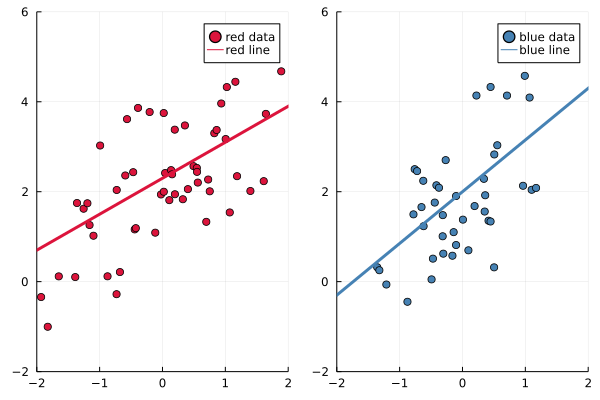

In [50]:
plot_dual = plot(red_plot, blue_plot, xrange=(-2, 2), yrange=(-2, 6))

In [51]:
savefig(plot_dual, "figures/plot_interaction_separated.pdf")

In [53]:
@model function interaction_model(N, xs, ys, cs)
    sigma_slopes ~ Exponential(0.05)
    
    a ~ filldist(Normal(0.0, 0.5), 2)
    
    b ~ filldist(Normal(0.0, 0.5), 2)
    
    sigma ~ Exponential(1.0)
    
    for i in 1:N
        if cs[i] == 1.0
            mu_1 = a[1] * xs[i] + b[1]
            ys[i] ~ Normal(mu_1, sigma)
        else
            mu_2 = a[2] * xs[i] + b[2]
            ys[i] ~ Normal(mu_2, sigma)
        end
    end
end

interaction_model (generic function with 2 methods)

In [54]:
m_interaction = interaction_model(100, interaction_samples[!,:x],
    interaction_samples[!,:y],
    interaction_samples[!,:flip])

chain_interaction = sample(m_interaction, NUTS(0.65), 5000)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /home/noric/.julia/packages/Turing/Tpj0b/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (5000×18×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 9.21 seconds
Compute duration  = 9.21 seconds
parameters        = sigma_slopes, a[1], a[2], b[1], b[2], sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std   naive_se      mcse         ess      rhat  ⋯
        Symbol   Float64   Float64    Float64   Float64     Float64   Float64  ⋯

  sigma_slopes    0.0512    0.0521     0.0007    0.0009   3853.6179    0.9999  ⋯
          a[1]    0.9362    0.1677     0.0024    0.0029   4875.7140    0.9999  ⋯
          a[2]    0.8677    0.1455     0.0021    0.0018   5445.6761    0.9999  ⋯
          b[1]    1.7004    0.1576     0.0022    0.0024   4355.6650    0.9999  ⋯
          b[2]    2.0215    0.

In [106]:
@model function interaction_model(N, xs, ys, cs)
    sigma_slopes ~ Exponential(0.05)
    
    a1 ~ Normal(0.0, sigma_slopes)
    a2 ~ Normal(0.0, sigma_slopes)
    
    b1 ~ Normal(0.0, 1.5)
    b2 ~ Normal(0.0, 1.5)
    
    sigma ~ Exponential(1.0)
    
    for i in 1:N
        if cs[i] == 1.0
            mu_1 = a1 * xs[i] + b1
            ys[i] ~ Normal(mu_1, sigma)
        else
            mu_2 = a2 * xs[i] + b2
            ys[i] ~ Normal(mu_2, sigma)
        end
    end
end

interaction_model (generic function with 2 methods)

In [107]:
m_interaction = interaction_model(100, interaction_samples[!,:x],
    interaction_samples[!,:y],
    interaction_samples[!,:flip])

chain_interaction = sample(m_interaction, NUTS(0.65), 5000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/noric/.julia/packages/Turing/Tpj0b/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (5000×18×1 Array{Float64, 3}):

Iterations        = 1001:1:6000
Number of chains  = 1
Samples per chain = 5000
Wall duration     = 3.19 seconds
Compute duration  = 3.19 seconds
parameters        = sigma_slopes, a1, a2, b1, b2, sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std   naive_se      mcse         ess      rhat  ⋯
        Symbol   Float64   Float64    Float64   Float64     Float64   Float64  ⋯

  sigma_slopes    0.4085    0.0866     0.0012    0.0012   4778.4889    1.0008  ⋯
            a1    1.0239    0.1116     0.0016    0.0018   4361.0630    0.9999  ⋯
            a2    0.5475    0.1372     0.0019    0.0016   6846.0446    1.0002  ⋯
            b1    2.0029    0.1201     0.0017    0.0016   5087.2109    0.9998  ⋯
            b2    2.2779    0.1643    

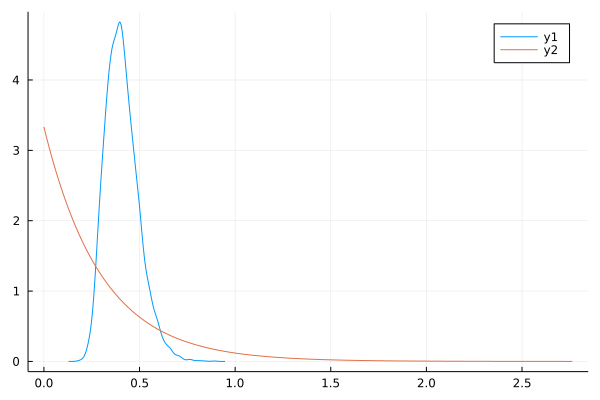

In [108]:
p = density(chain_interaction[:sigma_slopes])
plot!(p, Exponential(0.3))

The plot above shows that the slopes of the lines were a little more different than I expected.

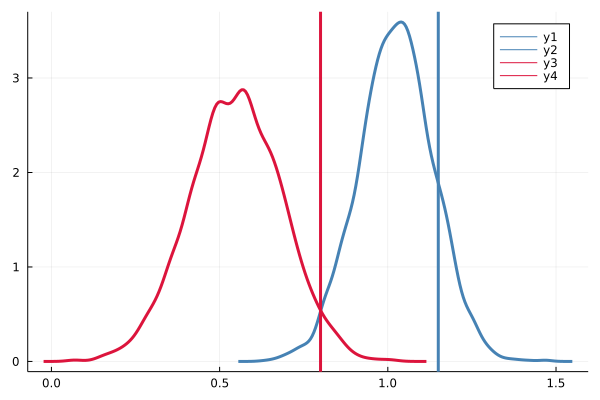

In [109]:
p = density(chain_interaction[:a1], color="steelblue", w=3)
vline!(p, [1.15], color="steelblue", w=3)

density!(p, chain_interaction[:a2], color="crimson", w=3)
vline!(p, [0.8], color="crimson", w=3)

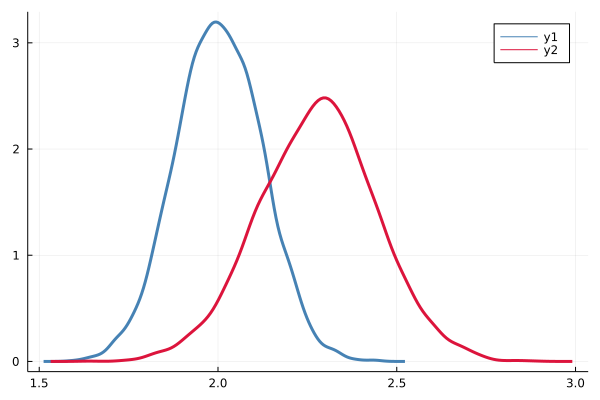

In [110]:
p = density(chain_interaction[:b1], color="steelblue", w=3)
density!(p, chain_interaction[:b2], color="crimson", w=3)